In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

#for warning
from warnings import filterwarnings
filterwarnings("ignore")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_road_shape = pd.read_csv("/content/drive/MyDrive/Projects/DS201/data/q1_road_shape.csv")
df_traffic = pd.read_csv("/content/drive/MyDrive/Projects/DS201/data/q1_traffic.csv")

In [4]:
df_traffic['density'] = df_traffic['segmentProbeCounts']/df_traffic['distance']

In [5]:
def get_start_time(time):
  return time[:time.index("-") - 1]

df_traffic["start_time"] = df_traffic["time"].apply(get_start_time)
df_traffic["timstart_time"] = pd.to_datetime(df_traffic["date"] + " " + df_traffic["start_time"])

In [6]:
#The day of the week with Monday=0, Sunday=6.
df_traffic['weekday'] = df_traffic["timstart_time"].dt.weekday
df_traffic["speedLimit"] = df_traffic["speedLimit"]/100

In [7]:
df_traffic['is_weekend'] = df_traffic['weekday'].apply(lambda x: 1 if x >= 5 else 0)
# sns.countplot(y='is_weekend', data = df_traffic)

<Axes: xlabel='count', ylabel='weekday'>

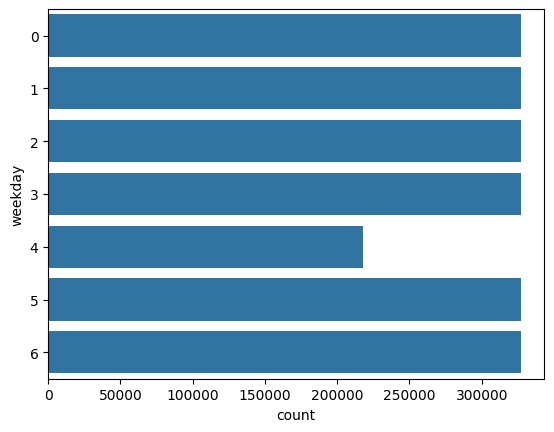

In [ ]:
# sns.countplot(y='weekday', data = df_traffic)

<Axes: xlabel='count', ylabel='frc'>

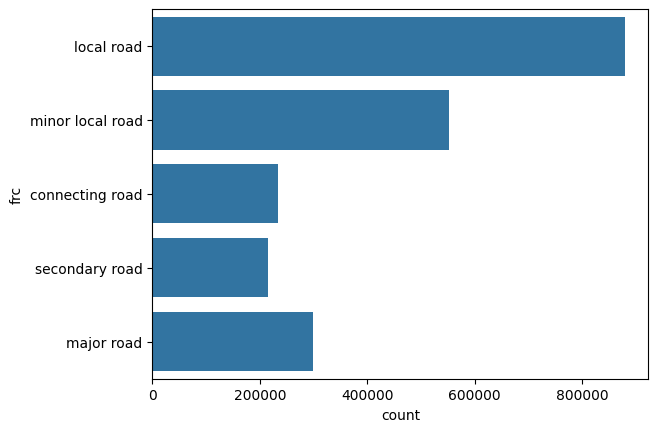

In [ ]:
# sns.countplot(y='frc', data = df_traffic)

<Axes: >

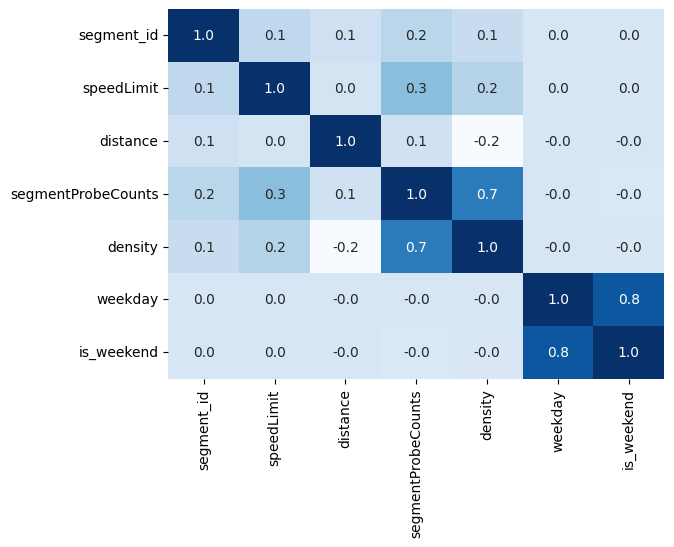

In [ ]:
# sns.heatmap(df_traffic.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

In [ ]:
#df_traffic.drop(columns=['date', 'time'], inplace = True)
#df_traffic.drop(columns='start_time', inplace = True)
#df_traffic.drop(columns='streetName', inplace = True)
# df_traffic.drop(columns='shape', inplace = True)

In [10]:
df_traffic_tmp = df_traffic[df_traffic['segment_id']==-17040033537648]
df_traffic_tmp = df_traffic[df_traffic['segment_id']==17040019002474]
df_traffic_tmp.sort_values(by='timstart_time', inplace=True)
df_traffic_tmp.reset_index(drop=True, inplace=True)

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_traffic_tmp['frc'] = label_encoder.fit_transform(df_traffic_tmp['frc'])

In [13]:
df_traffic_tmp.columns

Index(['segment_id', 'date', 'time', 'speedLimit', 'frc', 'streetName',
       'shape', 'distance', 'segmentProbeCounts', 'density', 'start_time',
       'timstart_time', 'weekday', 'is_weekend'],
      dtype='object')

-17040018945684

In [ ]:
df_traffic[df_traffic["segment_id"] == 17040019155537]

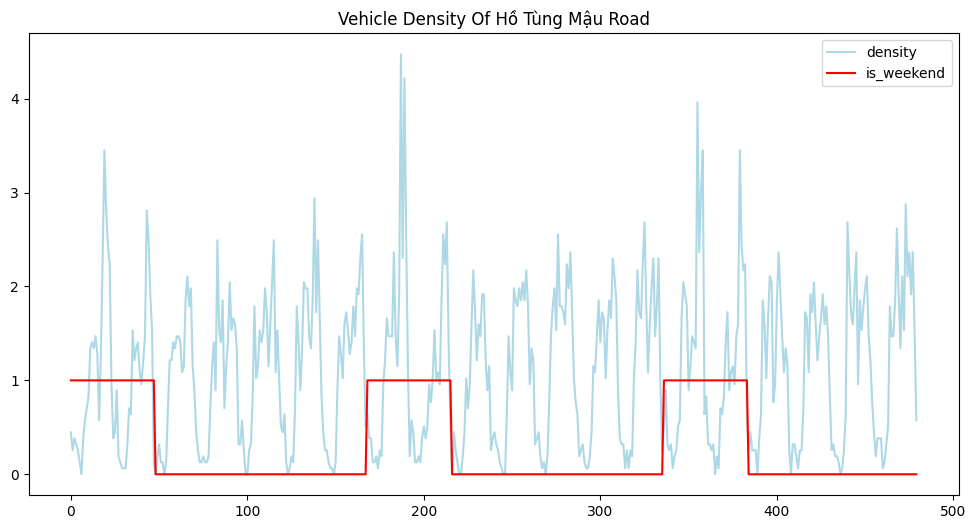

In [59]:
from matplotlib import pyplot
rand = df_traffic.sample()["segment_id"].values[0]
#rand = 17040021176927 # cuối tuần thấp, Đường Huỳnh Khương Ninh
rand = 17040019155537 # cuối tuần cao, Đường Hồ Tùng Mậu
df_traffic_tmp = df_traffic[df_traffic['segment_id']==rand]
df_traffic_tmp.sort_values(by='timstart_time', inplace=True)
df_traffic_tmp.reset_index(drop=True, inplace=True)

values = df_traffic_tmp.values
# specify columns to plot
groups = [9, -1]
# plot each column
pyplot.figure(figsize=(12,6))
pyplot.plot(values[:, 9], label="density", color="lightblue")
pyplot.plot(values[:, -1], label="is_weekend", color="red")
pyplot.title("Vehicle Density Of Hồ Tùng Mậu Road")
pyplot.legend()
pyplot.show()

In [ ]:
# def createXY(dataset,n_past):
#     dataX = []
#     dataY = []
#     for i in range(n_past, len(dataset)):
#             dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
#             dataY.append(dataset[i,0])
#     return np.array(dataX),np.array(dataY)

def to_sequences(df, seq_size, n_steps_ahead, col_name: str):
    x = []
    y = []
    dataset = df["density"].values
    dataset = dataset.reshape(-1, 1)

    for i in range(len(dataset) - seq_size - n_steps_ahead + 1):
        window_tmp = dataset[i:(i + seq_size), 0]
        att_plus = np.array([df[col_name][i]])
        window = np.concatenate((window_tmp, att_plus))
        target = dataset[i + seq_size:i + seq_size + n_steps_ahead, 0]
        x.append(window)
        y.append(target)
    return np.array(x), np.array(y)

In [ ]:
# X, y = to_sequences(df_traffic_tmp, 5, 1, "speedLimit")

In [ ]:
from tqdm import tqdm

segment_ids = df_traffic["segment_id"].unique()

X, y = None, None
SEQ_SIZE = 5
NUM_PRED = 1

for segment_id in tqdm(segment_ids):
    df_traffic_tmp = df_traffic[df_traffic["segment_id"] == segment_id]
    df_traffic_tmp.reset_index(inplace=True)
    if X is None and y is None:
        X, y = to_sequences(df_traffic_tmp, SEQ_SIZE, NUM_PRED, "speedLimit")
    else:
        X_tmp, y_tmp = to_sequences(df_traffic_tmp, SEQ_SIZE, NUM_PRED, "speedLimit")
        X = np.concatenate((X_tmp, X))
        y = np.concatenate((y_tmp, y))

100%|██████████| 4540/4540 [03:04<00:00, 24.60it/s]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
#X_train_crowded là dữ liệu cho những đoạn đường đông đúc
mean_values = np.mean(X_train, axis=1)
valid_indices = np.where(mean_values >= 1)[0]

X_train_crowded = X_train[valid_indices]
y_train_crowded = y_train[valid_indices]

mean_values = np.mean(X_test, axis=1)
valid_indices = np.where(mean_values >= 1)[0]

X_test_crowded = X_test[valid_indices]
y_test_crowded = y_test[valid_indices]

In [ ]:
X_train_crowded.shape

(643881, 6)

In [ ]:
X_test_crowded.shape

(78519, 6)

#model

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

NUM_MORE_ATT = 1
NUM_EPOCHS = 50

model = Sequential()
model.add(LSTM(64, input_shape=(None, SEQ_SIZE + NUM_MORE_ATT), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(16, activation='relu'))
model.add(Dense(NUM_PRED, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

X_train_crowded = np.reshape(X_train_crowded, (X_train_crowded.shape[0], 1, X_train_crowded.shape[1]))
X_test_crowded = np.reshape(X_test_crowded, (X_test_crowded.shape[0], 1, X_test_crowded.shape[1]))
model.fit(X_train_crowded, y_train_crowded, epochs=NUM_EPOCHS, batch_size=64, validation_data=(X_test_crowded, y_test_crowded), verbose=1)
loss = model.evaluate(X_test_crowded, y_test_crowded, verbose=1)
y_pred = model.predict(X_test_crowded)
r2 = r2_score(y_test_crowded, y_pred)
mae = mean_absolute_error(y_test_crowded, y_pred)
print(mae, "-" ,loss, " - ", r2)

Epoch 1/50
10061/10061 [==============================] - 61s 6ms/step - loss: 9.7942 - val_loss: 1.6198
Epoch 2/50
10061/10061 [==============================] - 56s 6ms/step - loss: 5.5935 - val_loss: 1.6263
Epoch 3/50
10061/10061 [==============================] - 57s 6ms/step - loss: 5.3165 - val_loss: 1.5842
Epoch 4/50
10061/10061 [==============================] - 55s 6ms/step - loss: 5.3243 - val_loss: 1.5934
Epoch 5/50
10061/10061 [==============================] - 53s 5ms/step - loss: 5.5079 - val_loss: 1.5776
Epoch 6/50
10061/10061 [==============================] - 58s 6ms/step - loss: 5.1542 - val_loss: 1.5563
Epoch 7/50
10061/10061 [==============================] - 55s 5ms/step - loss: 4.9972 - val_loss: 1.5914
Epoch 8/50
10061/10061 [==============================] - 55s 5ms/step - loss: 5.2053 - val_loss: 1.8032
Epoch 9/50
10061/10061 [==============================] - 54s 5ms/step - loss: 5.3911 - val_loss: 1.7556
Epoch 10/50
10061/10061 [==============================

In [ ]:
mae

0.31819534546789213

In [ ]:
loss

0.5817925930023193